In [61]:
# import the required libraries:
import os, sys
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [62]:
#Execute this script to set values for different parameters:
BATCH_SIZE = 64
EPOCHS = 50
LSTM_NODES =256
NUM_SENTENCES = 20000
MAX_SENTENCE_LENGTH = 50
MAX_NUM_WORDS = 20000
EMBEDDING_SIZE = 200

In [63]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []

count = 0
for line in open('./nob-eng/nob.txt', encoding="utf-8"):
    count += 1
    if count > NUM_SENTENCES:
        break
    if '\t' not in line:
        continue
    input_sentence = line.rstrip().split('\t')[0]
    output = line.rstrip().split('\t')[1]

    output_sentence = output + ' <eos>'
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Number of sample input:", len(input_sentences))
print("Number of sample output:", len(output_sentences))
print("Number of sample output input:", len(output_sentences_inputs))

Number of sample input: 7391
Number of sample output: 7391
Number of sample output input: 7391


In [64]:
print("English sentence: ",input_sentences[180])
print("Norweigan translation: ",output_sentences[180])

English sentence:  No problem!
Norweigan translation:  Ikke noe problem! <eos>


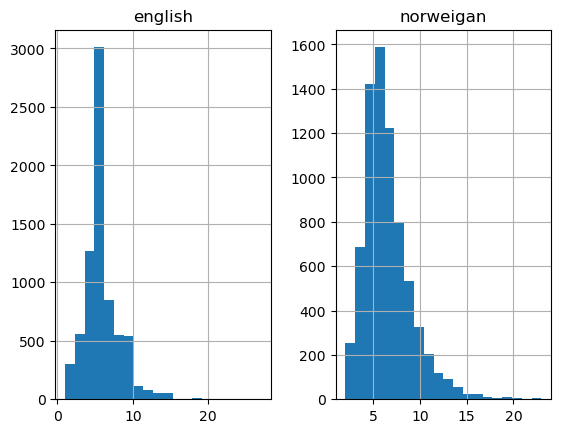

In [65]:
# let’s visualise the length of the sentences.
import pandas as pd

eng_len = []
nor_len = []

# populate the lists with sentence lengths
for i in input_sentences:
      eng_len.append(len(i.split()))  

for i in output_sentences:
      nor_len.append(len(i.split()))

length_df = pd.DataFrame({'english':eng_len, 'norweigan':nor_len})

length_df.hist(bins = 20)
plt.show()

In [66]:
#tokenize the input sentences(input language) 
input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)
print(input_integer_seq)

word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

#with open('input_tokenizer_NMT.pickle', 'wb') as handle:
#    pickle.dump(input_tokenizer, handle, protocol=4)

[[2063], [289], [76], [2064], [2065], [350], [350], [108], [584], [584], [1011], [214], [251], [251], [314], [585], [1, 275], [1, 705], [2066, 67], [503], [1012], [1523], [2067], [84, 11], [1, 35], [1, 182], [98], [634], [57, 17], [265, 5], [25, 1203], [25, 397], [25, 290], [200, 68], [69, 10], [69, 29], [79, 66], [79, 66], [40, 206], [1013], [1013], [12, 228], [12, 779], [108, 17], [108, 17], [1, 315], [1014, 17], [17, 121], [92, 2], [336, 17], [706, 51], [5, 705], [780, 51], [504], [76, 705], [57, 30], [2, 289], [2, 289], [40, 41], [64, 229], [64, 229], [12, 2068], [419, 51], [21, 1015], [21, 1015], [21, 872], [21, 1016], [21, 94], [26, 228], [26, 779], [707, 51], [5, 298], [5, 246], [5, 1017], [5, 182], [121, 193], [586, 17], [453, 17], [453, 68], [27, 315], [76, 228], [76, 299], [420, 12], [2069, 350], [873, 635], [1203, 194], [1203, 194], [69, 122], [69, 94], [69, 300], [636, 17], [1204], [637, 17], [637, 68], [546, 11], [79, 6, 229], [1205], [351, 151], [12, 2070], [12, 587], [12

In [67]:
#tokenize the output sentences(Output language)
output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)
print(output_input_integer_seq)

word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

#with open('output_tokenizer_NMT.pickle', 'wb') as handle:
#    pickle.dump(output_tokenizer, handle, protocol=4)

[[2, 1236], [2, 1696], [2, 2662], [2, 2663], [2, 2664], [2, 2665], [2, 710], [2, 2666], [2, 1237, 36], [2, 1237, 371], [2, 2667], [2, 1238], [2, 2668], [2, 1697], [2, 2669], [2, 1698], [2, 3, 1239], [2, 3, 2670], [2, 9, 2671], [2, 710], [2, 2672], [2, 2673], [2, 2674], [2, 3, 2675], [2, 3, 619], [2, 3, 1699], [2, 1700], [2, 372, 47, 5, 993], [2, 59, 215], [2, 827, 61], [2, 185, 2676], [2, 185, 491], [2, 185, 491], [2, 492, 157], [2, 87, 711], [2, 87, 1240], [2, 2677], [2, 87, 33, 120], [2, 69, 2678], [2, 38, 828], [2, 1241], [2, 15, 829], [2, 15, 830], [2, 620, 1701], [2, 620, 46], [2, 3, 4, 994], [2, 2679, 1701], [2, 3, 1702], [2, 19, 1703], [2, 413, 46], [2, 621, 2680], [2, 6, 1242], [2, 2681, 2682], [2, 2683], [2, 67, 2684], [2, 59, 270], [2, 5, 830], [2, 93, 830], [2, 69, 622], [2, 186, 2685], [2, 246, 2686], [2, 15, 1239], [2, 831, 2687], [2, 3, 4, 1704], [2, 3, 4, 1705], [2, 3, 4, 995], [2, 8, 76, 186, 18, 46], [2, 3, 4, 350], [2, 23, 829], [2, 23, 830], [2, 2688, 2689], [2, 6, 2

In [68]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[180]:", encoder_input_sequences[180])

encoder_input_sequences.shape: (7391, 27)
encoder_input_sequences[180]: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0  67 218]


In [69]:
print(word2idx_inputs["join"])
print(word2idx_inputs["us"])

1384
68


In [70]:
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[180]:", decoder_input_sequences[180])

decoder_input_sequences.shape: (7391, 23)
decoder_input_sequences[180]: [   2    7   51 2725    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]


In [71]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences.shape:", decoder_output_sequences.shape)


decoder_output_sequences.shape: (7391, 23)


In [72]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open(r'./glove.twitter.27B.200d/glove.twitter.27B.200d.txt', encoding="utf8")

for line in glove_file:
    rec = line.split()
    word = rec[0]
    vector_dimensions = asarray(rec[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [73]:
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))
for word, index in word2idx_inputs.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [74]:
print(embeddings_dictionary["join"])

[-3.7239e-01  4.7634e-01 -1.9666e-01 -1.1641e+00  1.2820e-02 -4.7063e-01
  4.4522e-01  1.8911e-01  5.6740e-01 -6.1915e-02  2.7159e-01 -1.7613e-01
 -5.4897e-01 -1.6782e-01  3.0910e-01  1.0253e-01  4.3412e-01 -4.0300e-02
  3.4782e-02  2.8017e-01  1.6735e-01 -5.3730e-02 -5.9838e-01 -6.7251e-02
 -7.0371e-01  1.0674e+00  4.1123e-01  2.6227e-01 -3.2041e-01  5.2882e-01
  3.6446e-01  1.3661e-01 -2.2680e-01  6.6556e-01  3.4684e-01 -4.1284e-01
  5.5050e-01  3.5691e-01  3.6985e-01 -3.1312e-01  9.2343e-02  1.7105e-01
 -1.5200e-01  6.4297e-02  2.2327e-01  2.9222e-01 -7.3356e-01 -4.6585e-02
 -2.1011e-01  1.2690e-01  3.1638e-01 -5.1846e-01  2.2601e-02 -1.6426e-01
 -8.4231e-02 -6.5978e-02 -1.4436e-01 -2.2150e-01  4.2886e-01  3.0813e-01
 -1.0191e-03  5.9619e-01  1.7514e-01  5.3788e-01 -6.3198e-01  1.5236e-01
 -1.9268e-01  5.8482e-03  6.8425e-01  5.9576e-01  4.4315e-01  3.5061e-01
  1.8628e-01  8.6317e-01  2.1811e-01 -2.6925e-02  1.4113e-01 -6.5218e-03
 -1.8793e-01 -7.6275e-01 -1.9529e-01 -3.8076e-01  2

In [75]:
print(embedding_matrix[464])

[-6.78140000e-02  7.40379989e-01 -3.73439997e-01  1.74710006e-01
 -5.65689981e-01  1.73579995e-02  5.02579987e-01  6.13870025e-01
 -4.70499992e-02 -2.66400009e-01  4.89769988e-02  3.40070009e-01
 -1.22119999e+00 -3.11789989e-01  3.72440010e-01  1.37850001e-01
  1.43179998e-01 -1.05490005e-02  1.03529997e-01  8.45419988e-02
  5.17650008e-01  6.40640020e-01 -1.54239997e-01 -5.19680023e-01
  2.86419988e-01  1.46019995e+00 -2.35630006e-01 -2.56000012e-01
 -6.36380017e-02 -4.24820006e-01 -1.00429997e-01  2.92230010e-01
 -6.10210001e-01  7.36649990e-01 -4.45499986e-01 -5.66679984e-02
 -3.05510014e-01 -8.08070004e-02 -1.32269999e-02 -4.19930011e-01
  7.74649978e-01  1.96539998e-01  5.08980006e-02 -1.01899996e-01
 -2.09710002e-01 -2.82819998e-02  8.98819983e-01 -1.82019994e-01
 -1.79509997e-01 -6.23329990e-02 -2.08989993e-01  4.61010002e-02
 -4.70759988e-01  3.47950011e-01  3.78600001e-01 -3.23549986e-01
 -3.33799988e-01  5.21290004e-02 -6.76859990e-02 -3.61240000e-01
 -3.02139997e-01  2.02810

In [76]:
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)


# Creating the Model



In [77]:
decoder_targets_one_hot = np.zeros((
        len(input_sentences),
        max_out_len,
        num_words_output
    ),
    dtype='float32'
)
decoder_targets_one_hot.shape

(7391, 23, 6317)

In [78]:
for i, d in enumerate(decoder_output_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

In [79]:
encoder_inputs = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

In [80]:
decoder_inputs = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

In [81]:
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [82]:
#Compile
model = Model([encoder_inputs,decoder_inputs], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 27)]         0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 23)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 27, 200)      745400      ['input_6[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 23, 256)      1617152     ['input_7[0][0]']                
                                                                                            

Let's plot our model to see how it looks.

In [83]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [84]:
history = model.fit([encoder_input_sequences, decoder_input_sequences], decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=50,
    callbacks=[es],
    validation_split=0.1,
)


Epoch 1/50
104/104 [==============================] - 67s 612ms/step - loss: 2.2438 - accuracy: 0.7324 - val_loss: 3.6330 - val_accuracy: 0.5200
Epoch 2/50
104/104 [==============================] - 66s 636ms/step - loss: 1.5584 - accuracy: 0.7743 - val_loss: 3.1412 - val_accuracy: 0.5659
Epoch 3/50
104/104 [==============================] - 83s 794ms/step - loss: 1.4680 - accuracy: 0.7906 - val_loss: 3.1068 - val_accuracy: 0.5731
Epoch 4/50
104/104 [==============================] - 75s 725ms/step - loss: 1.4281 - accuracy: 0.7930 - val_loss: 3.0497 - val_accuracy: 0.5774
Epoch 5/50
104/104 [==============================] - 66s 633ms/step - loss: 1.3926 - accuracy: 0.7972 - val_loss: 3.0349 - val_accuracy: 0.5811
Epoch 6/50
104/104 [==============================] - 63s 606ms/step - loss: 1.3548 - accuracy: 0.8023 - val_loss: 2.9909 - val_accuracy: 0.5872
Epoch 7/50
104/104 [==============================] - 64s 611ms/step - loss: 1.3173 - accuracy: 0.8077 - val_loss: 2.9397 - val_ac

In [85]:
model.save('seq2seq_eng-nor.h5')

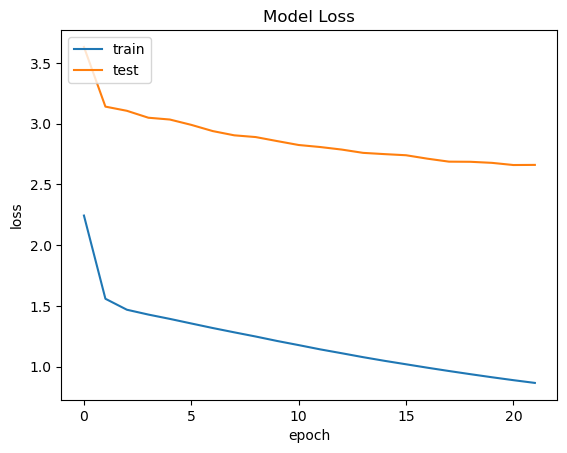

In [86]:
import matplotlib.pyplot as plt
# %matplotlib inline
plt.title('Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [87]:
encoder_model = Model(encoder_inputs, encoder_states)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.load_weights('seq2seq_eng-nor.h5')

In [88]:
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [89]:
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)


In [90]:
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [91]:
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

In [93]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [94]:
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

In [130]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('Input Language : ', input_sentences[i])
print('Actual translation : ', output_sentences[i])
print('Norwegian translation : ', translation)

1/1 [==============================] - 0s 20ms/step
Input Language :  I have two daughters.
Actual translation :  Jeg har to døtre. <eos>
Norwegian translation :  jeg har tre tre
